In [302]:
import torch
import stheno
import numpy as np
import matplotlib.pyplot as plt

from cnp.experiment import WorkingDirectory

from cnp.cnp import StandardConvGNP
from cnp.lnp import StandardConvNP

# from cnp.cov import (
#     MeanFieldGaussianLayer,
#     InnerprodGaussianLayer,
#     KvvGaussianLayer
# )

import os
import pickle

root = '/scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/synthetic'

In [307]:
# Directory where data are stored
data_type = 'eq'
data_name = f'{data_type}-2-8-50-100-100-0'

# Path to data
data_dir = os.path.join(root, 'toy-data', data_name)
data_directory = WorkingDirectory(root=data_dir)

# Load data
file = open(data_directory.file('valid-data.pkl'), 'rb')
data = pickle.load(file)
file.close()

Root: /scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/synthetic/toy-data/eq-2-8-50-100-100-0


In [308]:
# Generate data
def generate_dataset(data_type, num_context, num_total, noise=5e-2):
    
    # Set up covariance
    if data_type == 'eq':
        cov = stheno.EQ().stretch(1.)

    elif data_type == 'matern':
        cov = stheno.Matern52().stretch(1.)

    elif data_type == 'noisy-mixture-slow':
        cov = stheno.EQ().stretch(1.) + stheno.EQ().stretch(0.5)

    elif data_type == 'weakly-periodic-slow':
        cov = stheno.EQ().stretch(1.) * stheno.EQ().periodic(period=0.5)
        
    cov = cov + noise ** 2 * stheno.Delta()
    
    # Choose line to constrain along and choose inputs
    x0 = -2.
    x1 = 2.
    y0 = 4. * np.random.rand() - 2.
    y1 = 4. * np.random.rand() - 2.
    
    x = np.linspace(x0, x1, num_total)
    y = np.linspace(y0, y1, num_total)
    
    x = np.stack([x, y], axis=-1)
    
    # Sample data
    gp = stheno.GP(cov)
    sample = np.squeeze(gp(x).sample())
    
    idx = np.random.choice(np.arange(num_total), size=(num_context,))
    
    x_context = torch.tensor(x[idx, :])[None, :, :]
    y_context = torch.tensor(sample[idx])[None, :, None]
    x_target = torch.tensor(np.delete(x, idx, axis=0))[None, :, :]
    y_target = torch.tensor(np.delete(sample, idx))[None, :, None]
    
    return x_context.float(), x_target.float(), y_context.float(), y_target.float()

In [335]:
num_context = 3
num_total = 100

x_context, x_target, y_context, y_target = generate_dataset(data_type=data_type,
                                                            num_context=num_context,
                                                            num_total=num_total)

In [336]:
# List models
output_layers = [
    MeanFieldGaussianLayer(),
    InnerprodGaussianLayer(num_embedding=512, noise_type='homo'),
    KvvGaussianLayer(num_embedding=512, noise_type='homo')
]

output_layer_names = ['meanfield', 'innerprod', 'kvv']

gnp_models = [StandardConvGNP(input_dim=2, output_layer=output_layer) \
              for output_layer in output_layers]

model_suffix = f'/homo/identity/seed-0/dim-2/model_best.pth.tar'
gnp_model_paths = [f'{root}/results/{data_name}/models/convGNP/{output_layer_name}/{model_suffix}'
                   for output_layer_name in output_layer_names]

for gnp_model, gnp_model_path in zip(gnp_models, gnp_model_paths):
    gnp_model.load_state_dict(torch.load(gnp_model_path)['state_dict'])

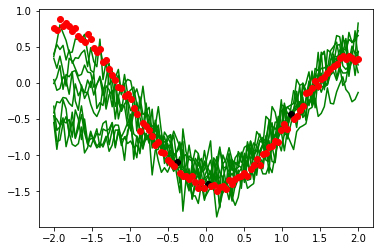

In [337]:
samples = gnp_models[1].sample(x_context,
                               y_context,
                               x_target,
                               num_samples=10,
                               noiseless=False,
                               double=True)

plt.plot(x_target[0, :, 0], samples[:, 0, :].T, color='green', zorder=1)
plt.scatter(x_context[0, :, 0], y_context[0, :, 0], color='black', zorder=2)
plt.scatter(x_target[0, :, 0], y_target[0, :, 0], color='red', zorder=2)
# plt.xlim([-0.5, 2.5])
# plt.ylim([-2.0, 0.5])
plt.show()

In [338]:
# List models
np_model = StandardConvNP(input_dim=2, num_samples=10)

model_suffix = f'/homo/identity/seed-0/dim-2/model_best.pth.tar'
np_model_path = f'{root}/results/{data_name}/models/convNP/meanfield/{model_suffix}'

np_model.load_state_dict(torch.load(np_model_path)['state_dict'])

<All keys matched successfully>

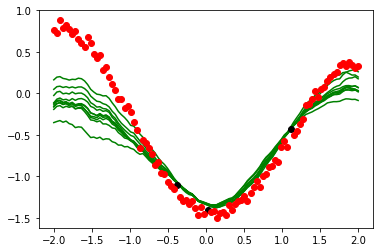

In [339]:
samples = np_model.forward(x_context, y_context, x_target, num_samples=10)[0].cpu().detach().numpy()

plt.plot(x_target[0, :, 0], samples[:, 0, :, 0].T, color='green', zorder=1)
plt.scatter(x_context[0, :, 0], y_context[0, :, 0], color='black', zorder=2)
plt.scatter(x_target[0, :, 0], y_target[0, :, 0], color='red', zorder=2)
# plt.xlim([-0.5, 2.5])
# plt.ylim([-2.0, 0.5])
plt.show()